In [1]:
# get rid of tensorflow warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL

# Task 2
## Task 2.1

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

# load the dataset along with info
(train_dataset, test_dataset), ds_info = tfds.load(
    "mnist", split=["train", "test"], as_supervised=True, with_info=True)

In [3]:
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

print(f"Shape of the images: {train_dataset.element_spec[0].shape}")

print(f"Pixel range: \n"
      f"\tMinimum value: {train_dataset.element_spec[0].dtype.min}\n"
      f"\tMaximum value: {train_dataset.element_spec[0].dtype.max}")

# Alternatively, most of the information can be found in df_info

Number of training images: 60000
Number of test images: 10000
Shape of the images: (28, 28, 1)
Pixel range: 
	Minimum value: 0
	Maximum value: 255


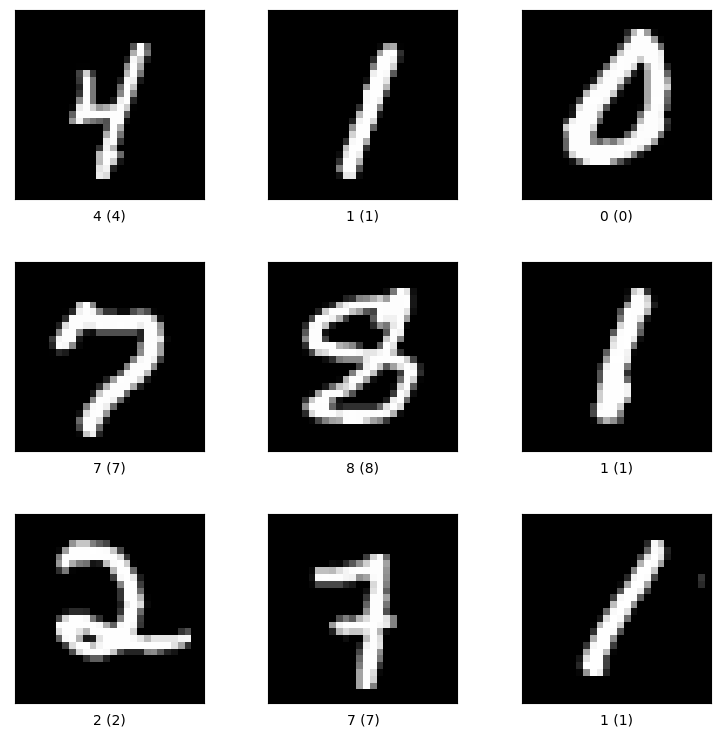

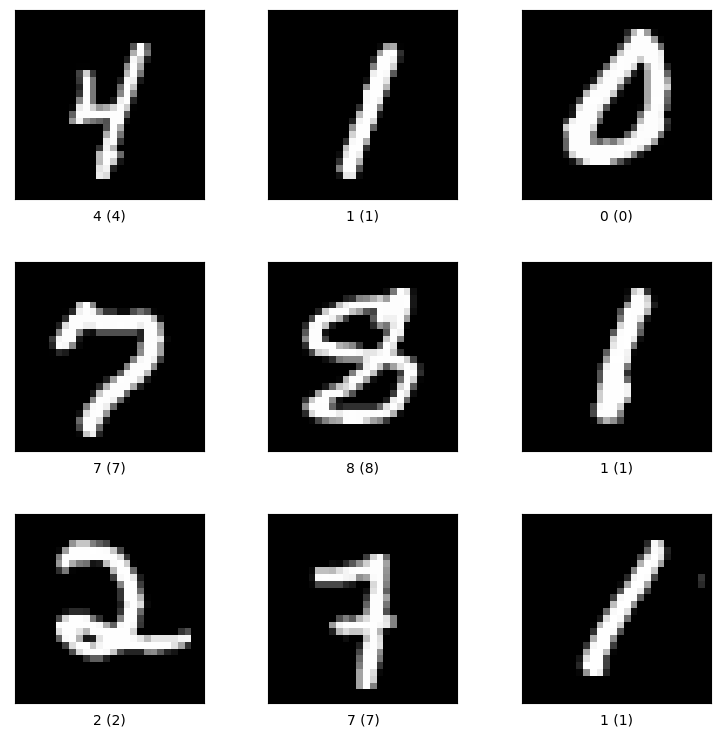

In [4]:
# example for showing examples in a dataset
tfds.show_examples(train_dataset, ds_info)

## Task 2.2

In [5]:
import numpy as np

def prepare_dataset(ds):
    # convert datatype from uint8 to float32
    ds = ds.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # flatten the input images
    ds = ds.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # normalize the image values
    ds = ds.map(lambda img, target: ((img/128.)-1., target))
    # encode labels as one-hot-vectors
    ds = ds.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    ds = ds.shuffle(1000)
    ds = ds.batch(32)
    ds = ds.prefetch(10)

    # for now, no shuffling/batching/prefetching is done
    return ds

train_ds = prepare_dataset(train_dataset)
test_ds = prepare_dataset(test_dataset)

## Task 2.3

In [6]:
from tensorflow.python.keras.layers import Dense

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.layer1 = Dense(256, activation=tf.nn.relu)
        self.layer2 = Dense(256, activation=tf.nn.relu)
        self.out = Dense(10, activation=tf.nn.softmax)
    
    @tf.function
    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        x = self.out(x)
        return x


## Task 2.4

In [7]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(prediction, target)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def test(model, test_ds, loss_function):
    test_accuracy_agg = []
    test_loss_agg = []

    for input, target in test_ds:
        prediction = model(input)
        sample_test_loss = loss_function(prediction, target)

        sample_test_accuracy = np.argmax(target, axis=1) \
                               == np.argmax(prediction, axis=1)

        test_loss_agg.append(sample_test_loss.numpy())
        test_accuracy_agg.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_agg)
    test_accuracy = tf.reduce_mean(test_accuracy_agg)

    return (test_loss, test_accuracy)


def train_loop(epochs, model, train_ds, test_ds, loss_function, optimizer):
    train_losses = []
    test_losses = []
    test_accuracies = []
    for epoch in range(epochs):
        epoch_loss_agg = []
        for input, target in train_ds:
            train_loss = train_step(model, input, target, loss_function, optimizer)
            epoch_loss_agg.append(train_loss)
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        test_loss, test_accuracy = test(model, test_ds, loss_function)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch: {str(epoch)} ending with accuracy {test_accuracies[-1]}")

    return (train_losses, test_losses, test_accuracies)

In [8]:
tf.keras.backend.clear_session()

num_epochs = 10
learning_rate = 0.01
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

model = MyModel()

train_losses, test_losses, test_accuracies = \
    train_loop(num_epochs, model, train_ds, test_ds, loss_function, optimizer)

Epoch: 0 ending with accuracy 0.09744408945686901
Epoch: 1 ending with accuracy 0.0972444089456869
Epoch: 2 ending with accuracy 0.0972444089456869
Epoch: 3 ending with accuracy 0.09744408945686901
Epoch: 4 ending with accuracy 0.09744408945686901
Epoch: 5 ending with accuracy 0.09734424920127796
Epoch: 6 ending with accuracy 0.09754392971246006
Epoch: 7 ending with accuracy 0.0972444089456869
Epoch: 8 ending with accuracy 0.0972444089456869
Epoch: 9 ending with accuracy 0.09734424920127796


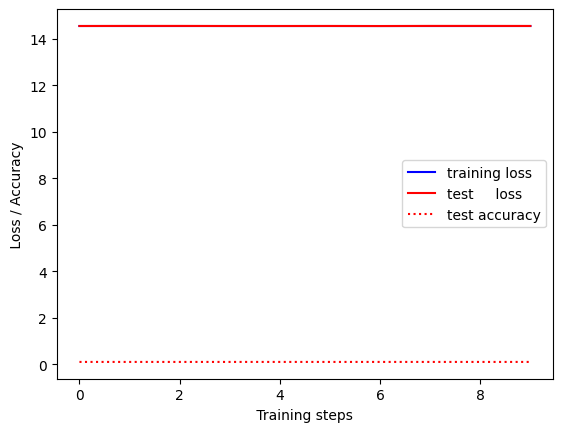

In [13]:
import matplotlib.pyplot as plt

def visualization(train_losses, test_losses, test_accuracies):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch .
    Loss is displayed in a regular line , accuracy in a dotted
    line .
    Training data is displayed in blue , test data in red .
    Parameters
    ----------
    train_losses : numpy.ndarray
    training losses
    train_accuracies : numpy.ndarray
    training accuracies
    test_losses : numpy.ndarray
    test losses
    test_accuracies : numpy.ndarray
    test accuracies
    """
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(test_accuracies, "r:")
    plt.xlabel(" Training steps ")
    plt.ylabel(" Loss / Accuracy ")
    plt.legend((line1, line2, line3), ("training loss", "test \
    loss", "test accuracy"))
    plt.show()

visualization(train_losses, test_losses, test_accuracies)